In [1]:
%matplotlib inline

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import re
import math
import baltic as bt

import requests
from io import StringIO as sio

import matplotlib.patches as patches



In [ ]:
# Paths to files
log_path = "C:/Users/iblag/Documents/flud/segment4_final_combined.log"

# Extract root heights from the log file
root_dates = []
with open(log_path, 'r') as f:
    for line in f:
        if line.startswith('state'):  # Identify header line
            header = line.strip().split('\t')
            root_index = header.index('age(root)')  # Get index for rootHeight column
        else:
            values = line.strip().split('\t')
            root_dates.append(float(values[root_index]))

# Compute statistics
root_mean = np.mean(root_dates)
root_median = np.median(root_dates)

# HPD interval calculation
def hpd(data, level):
    """
    Calculate the highest posterior density (HPD) interval for a given level.

    Args:
        data (array-like): A 1D array or list of samples from a posterior distribution.
        level (float): Credible interval level (e.g., 0.95 for a 95% HPD interval).

    Returns:
        tuple: A tuple (lower, upper) representing the bounds of the HPD interval.

    Docstring generated with ChatGPT 4o.
    """
    sorted_data = np.sort(data)
    n = len(data)
    interval_idx = int(np.floor(level * n))
    intervals = [(sorted_data[i], sorted_data[i + interval_idx]) for i in range(n - interval_idx)]
    hpd_interval = min(intervals, key=lambda x: x[1] - x[0])
    return hpd_interval

hpd_95 = hpd(root_dates, 0.95)

# Kernel density estimation (KDE) for the root heights
kde = gaussian_kde(root_dates, bw_method=0.3)
x_grid = np.linspace(min(root_dates), max(root_dates), 100)
y_grid = kde.evaluate(x_grid)

q1 = np.percentile(root_dates, 25)  # 1st quartile (Q1)
q3 = np.percentile(root_dates, 75)  # 3rd quartile (Q3)

print(f"Mean Root: {root_mean}")
print(f"Median Root: {root_median}")
print(f"95% HPD: {hpd_95}")
print(min(root_dates))


Mean Root: 1997.8593582168148
Median Root: 1998.4230744051697
95% HPD: (np.float64(1991.365580231495), np.float64(2003.175356823517))
1973.4625338229166



Tree height: 25.746325
Tree length: 454.136177
strictly bifurcating tree
annotations present

Numbers of objects in tree: 473 (236 nodes and 237 leaves)

Q1-Q3: 
1996.3699759977353-1999.9192429008165
3.549266903081161


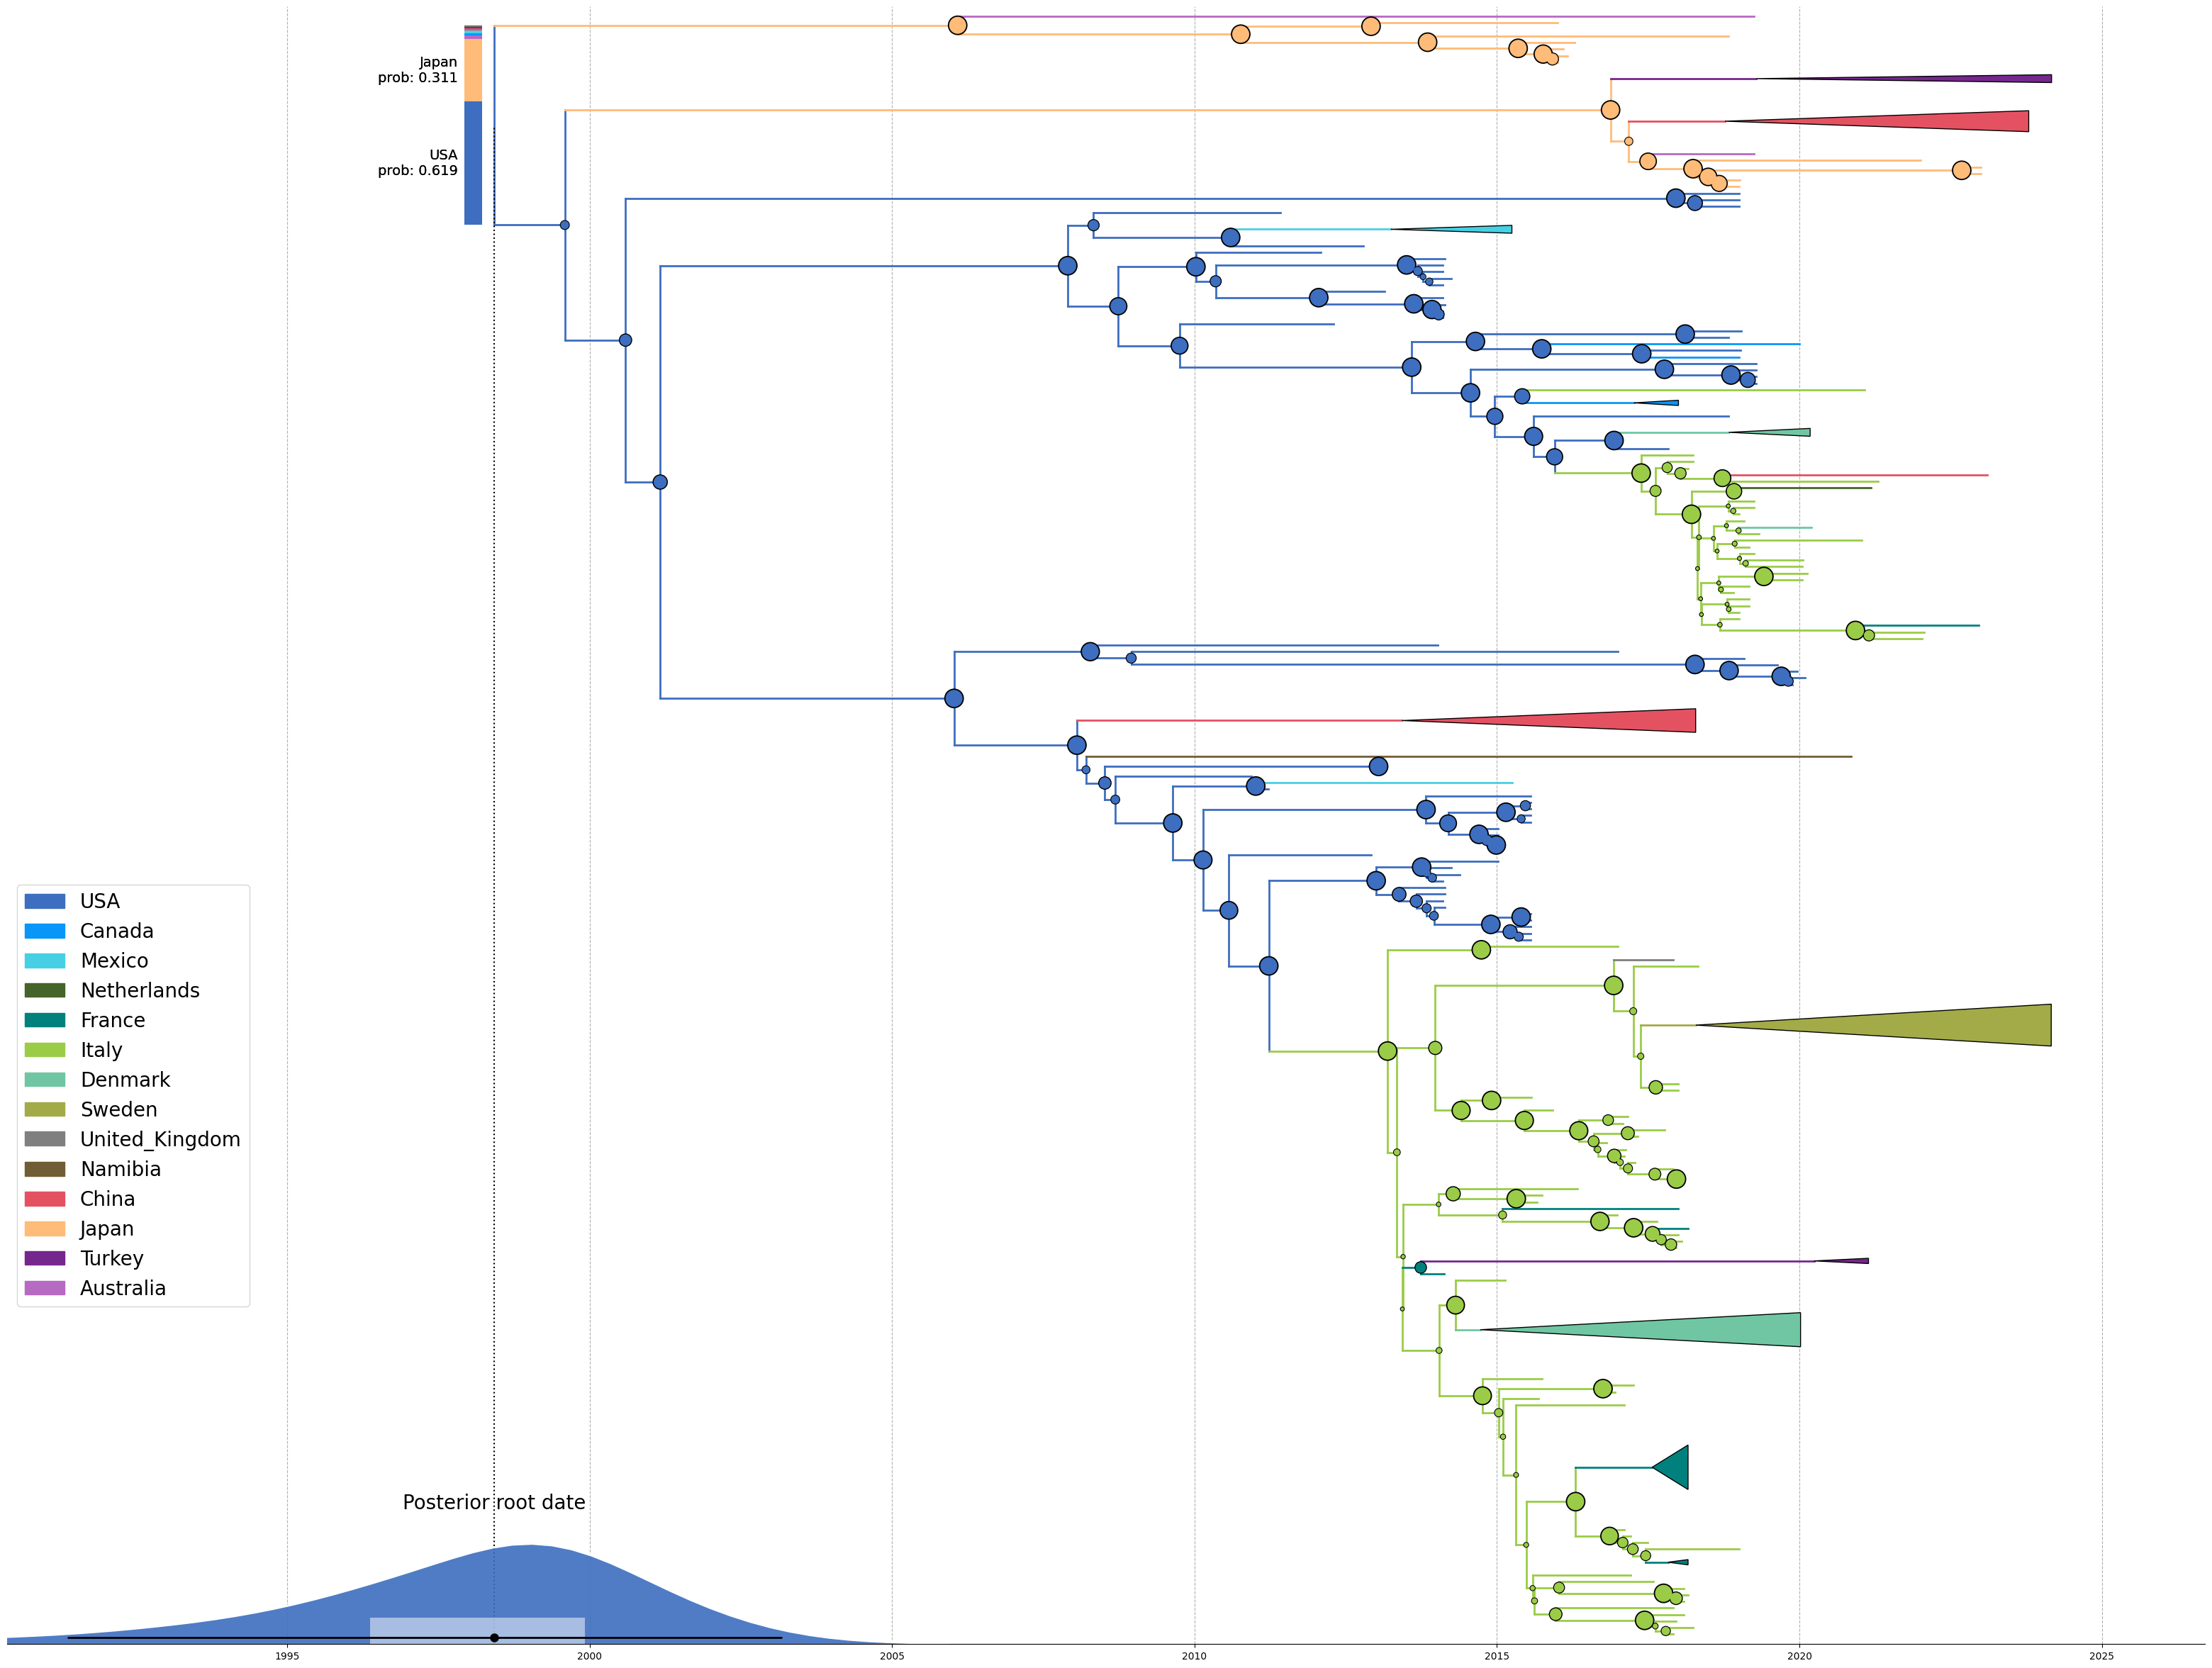

In [4]:
# Load the tree file
treefile = "C:/Users/iblag/Documents/flud/segment4_final.MCC.tree"
tree_object = bt.loadNexus(treefile, tip_regex=r'(\d{4}-\d{2}(?:-\d{2})?)$')

# Report stats about the tree
tree_object.treeStats()

# Set up figure and axis for plotting
fig, ax = plt.subplots(figsize=(40, 30), facecolor='w')

# Define the x attribute for plotting (absolute time)
x_attr = lambda k: k.absoluteTime

# Define path effects
effects = [path_effects.Stroke(linewidth=1, foreground='k')]
outline=1

# Define colors
state_color = {
    'USA': '#3D6EBF',
    'Canada': '#0896f9',
    'Mexico': "#47d0e4",
    
    'Netherlands': '#446429',
    'France': '#00817E',
    'Italy': '#9acc48',
    'Denmark': '#70c6a3',
    'Sweden': '#a3ab48',
    'United_Kingdom': '#7f7f7f',

    
    'Namibia': '#715d35',
    
    'China': '#E45262',
    'Japan': '#ffbb78',
    'Turkey': '#75278D',
    
    'Australia': '#B76AC2'
}


c_func = lambda k: state_color[k.traits['state']]

# seting min and max values
posterior_values = [k.traits['posterior'] for k in tree_object.Objects if k.is_node()]
min_posterior = min(posterior_values) if posterior_values else 0
max_posterior = max(posterior_values) if posterior_values else 1

# Define your desired size range
min_size = 10
max_size = 300

# linear scaling
size_func = lambda k: (min_size + (k.traits['posterior'] - min_posterior) / (max_posterior - min_posterior) * (
            max_size - min_size))  # if k.is_node() else min_size

outline_func = lambda k: 1.3*size_func(k) + 10  # if k.is_node() else min_size


node_target = lambda k: k.is_node() and k != tree_object.root # or k.is_leaf()

tree_object.uncollapseSubtree()  # to avoid errors in rerunning


def all_descendants_same_state(node):
    """
    Check if all descendants of the given node have the same 'state' trait as the node itself.

    Args:
        node: A tree node object with a `.traits` dictionary, `.children` list, and `.is_leaf()` method.

    Returns:
        bool: True if all descendants (children, grandchildren, etc.) have the same 'state'
              as the given node; False otherwise.
    """
    node_state = node.traits.get('state')
    if node_state is None:
        return False

    # Recursive function to check state consistency down the tree
    def check_state_recursively(descendant):

        # If it's a leaf, we just check its state
        if descendant.is_leaf():
            return descendant.traits.get('state') == node_state

        # If it's a node, check its state and then its descendants
        if descendant.traits.get('state') != node_state:
            return False
        for child in descendant.children:
            if not check_state_recursively(child):
                return False
        return True

    # Check each immediate child and all its descendants
    for child in node.children:
        if not check_state_recursively(child):
            return False

    return True

# Define collapse_target with the new check
collapse_target = lambda k: (
    k.is_node() and
    k.parent is not None and
    not k.is_leaf() and
    'state' in k.traits and
    'state' in k.parent.traits and
    k.traits['state'] != k.parent.traits['state'] and
    len(k.leaves) < 20 and
    all_descendants_same_state(k)  # Only collapse if all leaves match the node's state
)

check= tree_object.getBranches(collapse_target)

for idx, k in enumerate(tree_object.getBranches(collapse_target)):  ## iterate over branches that satisfy our function
    tree_object.collapseSubtree(k, 'clade %d' % (idx + 1))



# Debugging: Check if clades are identified correctly
clade_objects = lambda k: isinstance(k, bt.clade)  # Ensure correct class for clades

all_clades = tree_object.getBranches(clade_objects)

# Function to draw clades (only for clades that are external)
for clade in tree_object.getBranches(clade_objects):
    start_x = x_attr(clade)  # Starting position of the clade (x)
    end_x = clade.lastAbsoluteTime  # End position of the clade (last height in clade)
    y = clade.y  # Y position of the clade (same as for leaves)
    c = c_func(clade)  # Use the same color function as for the other nodes/branches


    y_offset = 0.0001 * len(tree_object.Objects)  # vertical offset 

    # Define the width for the clade 
    scaling_factor = 0.2
    clade_width = clade.width * scaling_factor

    # Coordinates for the triangle (clade polygon)
    lower_left = [start_x, y]
    upper_left = [start_x, y]
    upper_right = [end_x, y + clade_width]
    lower_right = [end_x, y - clade_width]

    # Create the polygon for the clade (triangle)
    clade_polygon = plt.Polygon((lower_left, upper_left, upper_right, lower_right),
                                facecolor=c, edgecolor='k', zorder=12,  linewidth= outline)
    ax.add_patch(clade_polygon)

# Plot tree
tree_object.plotTree(ax, x_attr=x_attr, colour=c_func)


# Plot the points (tips of the tree)
tree_object.plotPoints(ax, x_attr=x_attr, size=size_func, colour=c_func, zorder=100,  outline_colour='k', outline_size= outline_func, target=node_target)


# Add state probability to root of graph
for k in tree_object.Objects:
    if k.is_node and k.parent == tree_object.root:
        node= k.parent
        yl=node.children[0].y
        yr=node.children[-1].y
        
        location_states = node.traits['%s.set' % ("state")]
        location_probs = node.traits['%s.set.prob' % ("state")]
        join_probs = {a: b for a, b in zip(location_states, location_probs)}
        sort_locations = sorted(join_probs.keys(), key=lambda a: join_probs[a])
    
        width = 0.3
        heightRange = yr - yl
        start = yl
        
        for loc in sort_locations:
            height = heightRange * join_probs[loc]
            country = loc
            fc = state_color[loc]
            text = f"{loc}\nprob: {round(join_probs[loc], 3)}"
            if join_probs[loc] >= 0.1:
                ax.text(
                    # x_attr(node) - width -0.05, np.mean([start, start + height]), '%s' % (text),
                    x_attr(node) - width -0.3, np.mean([start, start + height]), '%s' % (text),
                    
                    rotation=0, zorder=101, va='center', ha='right', size=14
                )
            
            # ax.add_patch(plt.Rectangle((x_attr(node) - width + 0.05, start), width, height, facecolor=fc, zorder=100)) #edgecolor='k', lw=1,
            ax.add_patch(plt.Rectangle((x_attr(node) - width - 0.2, start), width, height, facecolor=fc, zorder=100)) #edgecolor='k', lw=1,

            
            start += height


root_color = state_color[sort_locations[-1]]
root_color2 = state_color[sort_locations[-2]]

# Add violin plot to the root of the tree
hpdLo, hpdHi = hpd_95
# root_y = [(y * 0.6) - 1 for y in y_grid]  # Scale KDE heights
root_y=[(y * 100) - 1 for y in y_grid]
topX = tree_object.root.absoluteTime
topY = tree_object.root.y 
bottomX = topX
bottomY = -1


# Add text above the plot
ax.text(
    x=topX,                   
    y=bottomY + 20,              
    s="Posterior root date",       
    fontsize=20,                
    ha='center',              
    va='bottom',               
    color='k',                 
    zorder=104                  
)

# Plot connection line and violin plot
ax.plot([bottomX, topX], [bottomY, topY], ls=':', color='k', zorder=98)
ax.fill_between(x_grid, root_y, y2=-1, facecolor=root_color, edgecolor='none', alpha=0.9, zorder=99)
ax.plot(x_grid, root_y, lw=2, color='w', ls='-', zorder=100)

# Add a horizontal line for HPD (High Posterior Density Interval)
ax.hlines(y=bottomY+1, xmin=hpdLo, xmax=hpdHi, color='k', lw=2, zorder=102, label="HPD")

print(f"Q1-Q3: \n{q1}-{q3}")
print(q3-q1)
# Add a rectangle for the IQR (Interquartile Range)
iqr_rect = patches.Rectangle(
    (q1, bottomY+1-2/2),  # Rectangle starting at the IQR low value
    q3 - q1,         # Width of the rectangle
    4,                   # Height of the rectangle (small, just enough to visualize)
    facecolor ="w",        # Rectangle color
    alpha=0.5,             # Transparency
    zorder=101,
    label="IQR"
)
ax.add_patch(iqr_rect)

# Add a dot for the median
ax.plot(root_median, bottomY+1, marker='o', color='k', markersize=8, zorder=103, label="Median")



# Adjust plot limits and appearance
ax.set_xlim(hpdLo - 1,)
ax.set_ylim(-1, tree_object.ySpan + 1)
ax.set_yticks([])
ax.set_yticklabels([])
ax.grid(axis='x', linestyle='--')

# Hide spines except the bottom one
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']]

# Create legend
legend_labels = [patches.Patch(color=state_color[country], label=country) for country in state_color]

# Add legend to the left side of the plot
ax.legend(handles=legend_labels, loc='lower left', bbox_to_anchor=(0, 0.2), fontsize=20, markerscale=6)


# Show plot
plt.show()